In [270]:
import time, math, cmath, argparse, random
import numpy as np
import scipy as sp
from scipy.linalg import expm,sqrtm
import qiskit as qs
from qiskit.quantum_info import random_unitary, random_clifford
from qiskit.opflow import I, X, Y, Z
from qiskit.quantum_info import Pauli
from tqdm import tqdm
import matplotlib.pyplot as plt

In [271]:
# 通过给定的H计算出相应N^{-1} channel的(X^D)^{-1}
def VX_calculate(H):
    dim = len(H)
    n = int(math.log(len(H), 2))

    # diagonalize the Hamiltonian H
    l, V = np.linalg.eig(H)

    V_abs = np.zeros((dim,dim),dtype = float)
    for i in range(dim):
        for j in range(dim):
            V_abs[i,j] = np.abs(V[i,j])**2

    X_mat = np.dot(V_abs.T,V_abs)
    X_inv = np.linalg.inv(X_mat)
    return l, V, X_mat, X_inv

def H_map(Post_state, V, X_mat, X_inv):

    D = len(Post_state)
    V_dag = V.conj().T
    # get the input state for channel N^{-1}
    P = np.dot(V_dag, np.dot(Post_state, V))

    rho_hat = P / X_mat
    rho_hat_diag = np.dot(X_inv,np.diag(P))
    diag = np.arange(D)
    rho_hat[diag,diag] = rho_hat_diag

    rho_hat = np.dot(V, np.dot(rho_hat, V_dag))
    return rho_hat

In [272]:
# Variance approximation
def Var_approx(obs,V,X_mat,M):
    dim = len(V)
    n = int(math.log(dim,2))

    V_dag = V.conj().T
    obs_spin = np.dot(V_dag,np.dot(obs,V))

    var = 0
    for i in range(dim):
        for j in range(dim):
            var += ((obs_spin[i][j]*obs_spin[j][i])/(X_mat[i][j]))
    var = var.real / dim
    var = var / M
    return var

# Variance ideal calculation
def Var_ideal(obs,rho,V,X_mat,X_inv,M):
    dim = len(V)
    n = int(math.log(dim,2))

    V_dag = V.conj().T
    obs_out = H_map(obs,V,X_mat,X_inv)
    obs_post = np.dot(V_dag,np.dot(obs_out,V))
    rho_post = np.dot(V_dag,np.dot(rho,V))

    var = 0
    for i in range(dim):
        for j in range(dim):
            for k in range(dim):
                # 计算 Y(i,j,k)
                y = 0
                for b in range(dim):
                    y += V[b][i]*V_dag[i][b] * V[b][j]*V_dag[j][b] * V[b][k]*V_dag[k][b]

                # 根据 i,j,k 有几个重复index分类
                if ((i==j) and (j==k)):
                    var += y*( obs_post[i][i]*obs_post[i][i]*rho_post[i][i] )
                elif i==j:
                    var += y*( obs_post[i][i]*obs_post[i][i]*rho_post[k][k] + 2*obs_post[i][k]*obs_post[i][i]*rho_post[k][i])
                elif j==k:
                    var += y*( obs_post[i][i]*obs_post[j][j]*rho_post[j][j] + obs_post[i][j]*obs_post[j][i]*rho_post[j][j] + obs_post[i][j]*obs_post[j][j]*rho_post[j][i] )
                elif k==i:
                    var += y*( obs_post[i][i]*obs_post[j][j]*rho_post[i][i] + obs_post[i][j]*obs_post[j][i]*rho_post[i][i] + obs_post[i][i]*obs_post[j][i]*rho_post[i][j] )
                else:
                    var += y*( obs_post[i][i]*obs_post[j][j]*rho_post[k][k] + obs_post[i][i]*obs_post[j][k]*rho_post[k][j] + obs_post[i][j]*obs_post[j][i]*rho_post[k][k] + obs_post[i][j]*obs_post[j][k]*rho_post[k][i] + obs_post[i][k]*obs_post[j][i]*rho_post[k][j] + obs_post[i][k]*obs_post[j][j]*rho_post[k][i] )

    # print('almost, var=', var)

    var = var - (np.trace(np.dot(rho,obs)))**2

    var = var.real
    var = var / M
    return var

def Var_global(obs,rho,M):
    dim = len(rho)
    part1 = np.trace(np.dot(obs,obs)) + 2*np.trace(np.dot(np.dot(obs,obs),rho))
    part2 = 2*np.trace(obs)*np.trace(np.dot(obs,rho)) + (np.trace(obs))**2
    part3 = (np.trace(np.dot(obs,rho)))**2
    var = ((dim+1)*part1)/(dim+2) - part2/(dim+2) - part3
    var = var.real / M
    return var

In [273]:
def Get_rho(n):
    # 随机纯态
    U0 = random_unitary(2**n).to_matrix()
    rho0 = np.diag([1]+[0]*(2**n-1))
    rho = np.dot(U0, np.dot(rho0, U0.conj().T))

    return rho

def Get_obs(obs_type):
    # X+Y+Z
    if obs_type==0: 
        obs = (X+Y+Z).to_matrix()
    elif obs_type==1:
        obs = X.to_matrix()
    elif obs_type==2:
        obs = Y.to_matrix()
    elif obs_type==3:
        obs = Z.to_matrix()

    return obs

def Get_lvx(theta):

    H = np.cos(theta) * Z.to_matrix() + np.sin(theta) * X.to_matrix()
    l,V,X_mat,X_inv = VX_calculate(H)
    
    return l,V,X_mat,X_inv

In [274]:
M = 1000
obs_type = 0
theta_num = 2000
theta_max = 1
n = 1

In [275]:
theta_table = np.linspace(0,theta_max*np.pi, theta_num+2)
theta_table = theta_table[1:theta_num+1]

# data[theta_idx]
data = np.zeros((theta_num))

In [276]:
print('---- Single qubit check:')
if obs_type==0:
    print('** Observable = X+Y+Z')
print('M=', M)
print('number of points:', theta_num)
print('max value of theta:', theta_max, '*Pi')
print('--------------------------------')
print('')

############################# run

# Get state rho
rho = Get_rho(n)

# Get observable obs
obs = Get_obs(obs_type)

for theta_idx in range(theta_num):
    theta = theta_table[theta_idx]

    # Get Hamiltonian H , 直接从prep中读取
    l,V,X_mat,X_inv = Get_lvx(theta)

    # Start RUNNING!
    var = Var_ideal(obs,rho,V,X_mat,X_inv,M)
    # var = Var_global(obs,rho,M)
    # std = np.sqrt(var)
    data[theta_idx] = var

var_global = Var_global(obs,rho,M)
np.save('./store/data_single_X+Y+Z.npy',data)
print('---- Finished!')

---- Single qubit check:
** Observable = X+Y+Z
M= 1000
number of points: 2000
max value of theta: 1 *Pi
--------------------------------



---- Finished!


In [277]:
y = data
x = theta_table
print(y[500])
print(var_global)

0.007908366035514409
0.008908316159560987


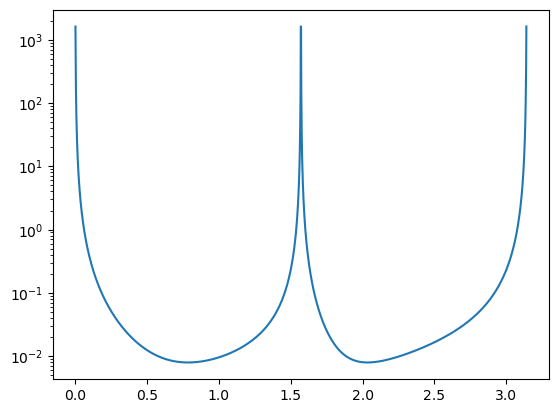

In [278]:
plt.plot(x, y, marker='.', linewidth=1.5, linestyle='-', markersize=0)
plt.yscale('log')
# plt.xscale('log')